In [ ]:
%pip install google-genai
%pip install matplotlib
%pip install os
%pip install dotenv
%pip install pydantic

In [ ]:
from google import genai
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from dotenv import load_dotenv
from google.genai import types
from pydantic import BaseModel, Field
from typing import List

In [ ]:
class FacialAnalysis(BaseModel):
    percentage: int = Field(description="Integer similarity score.")
    similarities: List[str] = Field(description="Key similarities.")
    differences: List[str] = Field(description="Key differences.")

In [ ]:
def create_genai_client():
    import os

    api_key = os.getenv("GOOGLE_API_KEY")
    if not api_key:
        raise ValueError("GOOGLE_API_KEY not found in .env file")    

    # Configure the client with your API key
    client = genai.Client(api_key=api_key, http_options={'api_version': 'v1alpha'})

    return client

In [ ]:
load_dotenv()

# Configure the client with your API key
client = create_genai_client()

In [ ]:
def load_image(image_path: str):
    try:
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"Error: The file at '{image_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
def get_inline_data_part(image_path: str):
    import mimetypes

    try:
        mime_type, _ = mimetypes.guess_type(image_path)
        if mime_type is None:
            mime_type = 'application/octet-stream'
            print(f"Warning: Could not determine MIME type for {image_path}. Defaulting to {mime_type}.")

        file_bytes: bytes | None = None
        with open(image_path, "rb") as image_file:
            file_bytes = image_file.read()
        
        if file_bytes is None:
            raise Exception(f"Unable to read the bytes from {image_path}")
    
        return types.Part(
            inline_data=types.Blob(
                mime_type=mime_type,
                data=file_bytes
            ),
            media_resolution={"level": "media_resolution_high"}
        ) 
    except FileNotFoundError:
        print (f"Error: The file was not found at {image_path}")
    except Exception as e:
        print (f"An error occurred: {e}")

In [ ]:
prompt = """
Role: You are an Expert Biometric Analyst and Facial Recognition Specialist. Your expertise lies in anthropometric comparison, analyzing facial landmarks, bone structure, and morphological traits.

Task: Analyze the attached image(s). Compare the physical appearance of the two individuals shown. If two separate images are provided, treat the first as Person A and the second as Person B. If one image containing two people is provided, treat the person on the left as Person A and the person on the right as Person B.

Analysis Criteria:
Focus strictly on biological and physical traits (facial geometry, feature shapes, and proportions). Ignore clothing, lighting, camera angles, or accessories (glasses, hats) unless they obscure features.

The Rule of Similarity (Visual Scoring Rubric):
You must assign a final similarity percentage based strictly on this scale:

0% - 10% (Dissimilar): Polar opposites. No shared facial geometry or features; different phenotypes.
11% - 20% (Faint Connection): Very weak link; perhaps a shared broad head shape, but all specific features differ.
21% - 30% (Vague Resemblance): Superficial similarities only (e.g., similar eye color or hair texture only), but the faces look unrelated.
31% - 40% (Partial Overlap): Noticeable but minor similarities. Maybe the nose or mouth is similar, but the overall bone structure is different.
41% - 50% (Moderate Association): Reminiscent. One major anatomical zone aligns (e.g., eyes/brows), but the rest of the face is distinct.
51% - 60% (Balanced Similarity): Comparable. Distinct individuals, but there is enough overlap in bone structure to suggest a relation.
61% - 70% (Strong Resemblance): "Cousin" status. Strong resemblance in the "map" of the face; differences are only in the details/nuance.
71% - 80% (Kindred Spirits): High resemblance. They share facial ratios that suggest a blood relation (e.g., parent/child or first cousins), but are clearly distinguishable as different people.
81% - 90% (Biological Sibling / Doppelgänger): Extremely high correlation. This tier represents biological sisters/brothers who look very similar, or unrelated high-grade lookalikes. They share almost all facial features, with only minor structural variances.
91% - 100% (Identical Match): The same person or identical twins. Facial geometry and bone structure are exact matches. Any visible differences are strictly superficial (e.g., age, styling, or weight) and not structural.

Output Format:
Please provide the result strictly in the following format:

Similarity Score: [Insert Integer]%

Key Similarities:
- [Detail 1]
- [Detail 2]
- [Detail 3]

Key Differences:
- [Detail 1]
- [Detail 2]
- [Detail 3]
"""

In [ ]:
def analyse_facial_images(person_a_image: str, person_b_image: str):
    response = client.models.generate_content(
        model="gemini-3-pro-preview",
        contents=[
            types.Content(
                parts=[
                    types.Part(text=prompt),
                    get_inline_data_part(person_a_image),
                    get_inline_data_part(person_b_image),
                ]
            )
        ],
        config=types.GenerateContentConfig(
            response_mime_type="application/json",
            response_json_schema=FacialAnalysis.model_json_schema()
        )
    )

    result = FacialAnalysis.model_validate_json(response.text)
    return result

def print_result(person_a_image: str, person_b_image: str):
    result = analyse_facial_images(person_a_image=person_a_image, person_b_image=person_b_image)

    load_image(person_a_image)
    load_image(person_b_image)
    print("Percentage: ", result.percentage)
    print ("Similarities:")
    for s in result.similarities:
        print("- ", s)

    print ("Differences:")
    for d in result.differences:
        print("-",  d)

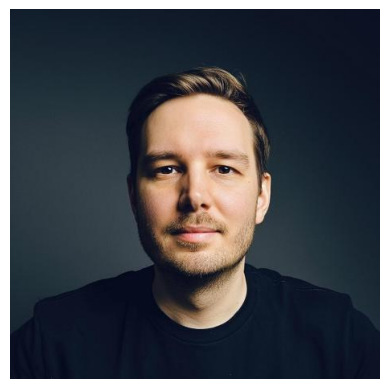

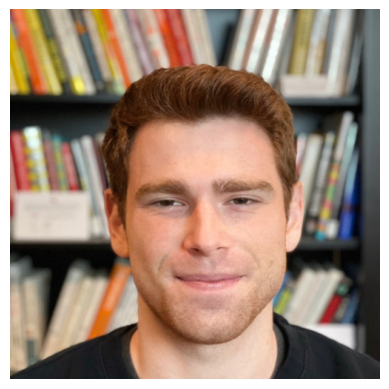

Percentage:  32
Similarities:
-  Both individuals share a similar high forehead structure and hairline recession pattern at the temples.
-  Vertical facial proportions are comparable, particularly the distance from the nasal bridge to the mouth.
-  Both feature similar grooming styles with short facial stubble and comparable hair length.
Differences:
- Facial geometry differs significantly; Person A has an oval/oblong face shape, while Person B has a much squarer face with a wider, stronger jawline.
- The orbital region is distinct; Person B has deeper-set eyes with a heavier, more prominent brow ridge compared to the flatter brow of Person A.
- Pigmentation is a major variance, with Person A having dark brown hair and Person B exhibiting reddish-brown (ginger) hair and facial hair.
- Chin structure varies, with Person B possessing a broad, flat chin compared to the narrower, rounded chin of Person A.
Error: The file was not found at ./images/Natalie_Portmanick.jpg


ValidationError: 1 validation error for Content
parts.1
  Input should be a valid dictionary or object to extract fields from [type=model_attributes_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.12/v/model_attributes_type

In [ ]:
persons = [
    ['./images/patrick.jpg', './images/logan_kilpatrick.jpg'],
    ['./images/Natalie_Portman.jpg', './images/Little_S.jpg'],
    ['./images/park_bo_gum.jpg', './images/Little_S.jpg'],
    ['./images/Ashley_Olsen.jpg', './images/Mary_Kate_Olsen.jpg'],
    ['./images/Big_S.jpg', './images/Little_S.jpg'],
    ['./images/Natalie_Portman.jpg', './images/Keira_Knightley.jpg'],
    ['./images/park_bo_gum.jpg', './images/lee_hyun_woo.jpg'],
    ['./images/patrick.jpg', './images/patrick.jpg'],
]

for item in persons:
    print_result(person_a_image=item[0], person_b_image=item[1])